In [2]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
@Time    :   26/07/2024 15:25:21
@Author  :   Marty 
'''

from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')
from IPython.display import display, Markdown

import numpy as np
from matplotlib import pyplot as plt


import math 
import pandas as pd
import os
from scipy.linalg import lu, solve

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4671/1353762519.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4671/1353762519.py:10: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


# **Caso cilindro con temperatura costante ($\sim$ sfera)**

$$
\frac{\partial C(r,z,T)}{\partial t} = \underline{\underline{D}}(r, z, T, \dot{F}) \nabla^2 C(r,z,T)  + S 
$$
In coordinate cilindriche: 
$$
\frac{\partial C(r,z,T)}{\partial t} = \underline{\underline{D}}(r, z, T, \dot{F}) \frac{1}{r^2} \frac{\partial}{\partial r} \left(r^2 \frac{\partial}{\partial r}C(r,z,T)\right) + \frac{\partial}{\partial z} \left(\underline{\underline{D}}(r, z, T, \dot{F}) \frac{\partial}{\partial z} C(r,z,T) \right) + S 
$$
dove $S = \dot{F} \cdot y$ con $y$ il fission yield. 

$\texttt{Adimensionalizzazione}$) adimensionalizziamo lungo la direzione $z$: 
$$
L^2  \frac{\partial C(r,z,T)}{\partial t} = L^2 \nabla \cdot (\underline{\underline{D}} \nabla C(r,z,T)) + SL^2
$$
Linear combination: 
$$
C= \sum_{i=1}^{N} a_i(t) \phi_i(r)
$$

$$
L^2 \sum_{i=1}^{N} \phi_i(r) \frac{\partial a_i(t)}{\partial t} = L^2 \underline{\underline{D}} \sum_{i=1}^{N} (a_i(t) \nabla ^2 \phi_i(r)) + L^2 S
$$
Galerkin projection:
$$ 
L^2 \sum_{i=1}^{N} \frac{\partial a_i(t)}{\partial t} \int_{\Omega} \phi_j(r) \cdot \phi_i(r) d\Omega = L^2 D a_i (t) \int_{\Omega} \phi_j(r) \cdot \nabla^2 \phi_i(r) d\Omega + L^2 S \int_{\Omega} \phi_j(r) d\Omega
$$
Con le matrici:
$$
\sum_{i=1}^{N} = \frac{D}{R^2} \ a_i (t) \ X_{ij} + S P_i
$$
dove $X_{ij} = < \phi_j(r), \nabla \cdot (\underline{\underline{G}} \nabla \phi_i(r))>_{L^2}$ e $P_j=<\phi_j(r)>_{L^2}$ con: 
$$
\underline{\underline{G}} = \begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & \frac{R^2}{L^2}
\end{bmatrix}
$$
di modo da poter portare fuori D in cui ho raccolto $R^2$ 

In [3]:
def lu_gauss(N, A, b):
    """
    @brief LU decomposition, Doolittle algorithm, according to @ref Dahlquist, Germund, Ake Bjorck & Anderson, Ned, Numerical Methods, Prentice Hall, 1974.
    La funzione esegue prima la decomposizione LU della matrice di input (A) memorizzando in essa le matrici inferiori e superiori.
    Quindi, la soluzione del sistema viene eseguita utilizzando la matrice fattorizzata e un metodo di sostituzione all'indietro.
    La soluzione viene memorizzata e restituita nel vettore b.
    NB: Questa funzione può essere utilizzata anche per eseguire solo la decomposizione stessa (ad esempio, per il precondizionamento)
    passando un vettore rhs fittizio.
    
    @param[in] N dimensione
    @param[in] A matrice del sistema lineare (in forma di array 1d)
    @param[in] b vettore RHS
    
    @param[out] b soluzione
    """
    
    A = np.reshape(A, (N, N)).astype(float)
    b = b.astype(float)
    y = np.zeros(N, dtype=float)

    # Decomposizione LU
    for k in range(N):
        for j in range(k, N):
            s = sum(A[k, l] * A[l, j] for l in range(k))
            A[k, j] -= s
        for i in range(k + 1, N):
            s = sum(A[i, l] * A[l, k] for l in range(k))
            A[i, k] = (A[i, k] - s) / A[k, k]

    # Risoluzione del sistema Ly = b
    for i in range(N):
        s = sum(A[i, k] * y[k] for k in range(i))
        y[i] = b[i] - s
        

    # Risoluzione del sistema Ux = y
    for i in range(N-1, -1, -1):
        s = sum(A[i, k] * y[k] for k in range(i + 1, N))
        y[i] = (y[i] - s) / A[i, i]

    return y

In [4]:
# Matrice X (presente nel file Xmatrix.txt)
matrix_X = np.array([
    [-6.062318975995, -2.7035145378486, -1.3791297022073, -1.1560379218819, 0.9945298432345],
    [-2.7035145378484, -36.614334897499, -19.661016795757, -16.118322843694, 13.72123874411],
    [-1.3791297022073, -19.661016795755, -61.470169990529, -58.473674584098, 48.222943967389],
    [-1.1560379218819, -16.11832284369, -58.473674584092, -77.462156522493, 76.704588938941],
    [0.99452984323413, 13.72123874411, 48.222943967387, 76.704588938938, -184.4680681132]
])

# Vettore P (presente nel file Pmatrix.txt)
vector_P = np.array([
    1.5356886500456,
    0.67393923527722,
    0.34442727115984,
    0.28872377588438,
    -0.24838569317319
])

basesC_average_volume = np.array([
    0.4908408929028,
    0.21540625177888,
    0.11008676095324,
    0.092282661562384,
    -0.079389696223766
])

In [5]:
def turnbull_diffusion(temperature, fission_rate):
    boltzmann_constant=1.380649e-23
    d1_sciantix = 7.6e-10 * np.exp(-4.86e-19 / (boltzmann_constant * temperature))
    d2_sciantix = 4.0 * 1.41e-25 * np.sqrt(fission_rate) * np.exp(-1.91e-19 / (boltzmann_constant * temperature))
    d3_sciantix = 8.0e-40 * fission_rate
    diff_turnbull_sciantix = d1_sciantix + d2_sciantix + d3_sciantix
    return diff_turnbull_sciantix

grain_radius = 1e-5

def C1 (temperature, fission_rate): 
    C1 = turnbull_diffusion(temperature, fission_rate)/pow(grain_radius,2);
    return C1

def source_term (fission_rate, fission_yield): 
    source_term = fission_rate * fission_yield
    return source_term

dimC = 5

#Valori da mettere in OF-8
boltzmann_constant=1.380649e-23
D1 = 7.6e-10
E1 = 4.86e-19 / boltzmann_constant
D2 = 4.0 * 1.41e-25
E2 = 1.91e-19 / boltzmann_constant
D3 = 8.0e-40
print(D1, E1, D2, E2, D3)

print('Fission yield OF', 0.24/6.022e23)

7.6e-10 35200.836707954004 5.64e-25 13834.073685636247 8e-40
Fission yield OF 3.9853869146462966e-25


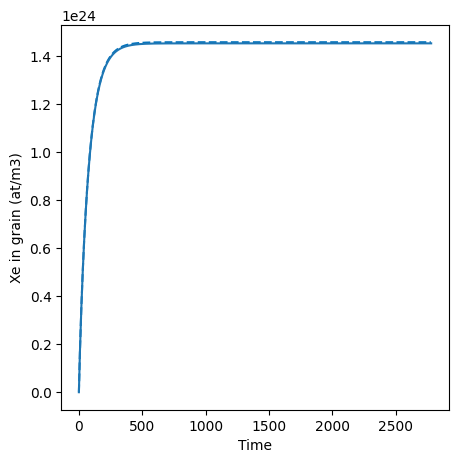

In [6]:
#Da mettere qui altrimenti cosi se rilancio il codice vengono ri-inizializzate
initial_condition = np.zeros(dimC)
lhs_C = np.zeros((dimC, dimC))
rhs_C = np.zeros((dimC))
I_C = np.eye(dimC)

# Time loop
t_end = 1e7  # end time
time_step = 1000 #quanti time step voglio
dt = t_end/time_step  # time step
t = 0.0  # current time
step = 1
solution_vector = np.zeros((int(time_step)+2,))

temperature = 2145
fission_rate = 3e19
fission_yield = 0.24


while t <= t_end:
    for i in range(dimC):
            for j in range(dimC):
                lhs_C[i, j] = I_C[i, j] - C1(temperature, fission_rate) * dt * matrix_X[i, j]

    # RHS temperatura
    for i in range(dimC):
        rhs_C[i] = initial_condition[i] + source_term(fission_rate, fission_yield) * dt * vector_P[i]

    x = lu_gauss(dimC, lhs_C.flatten(), rhs_C)
    #x = solve(lhs_C, rhs_C)   #con il solver di python

    # Aggiornamento di initial_condition con rhs_T
    for i in range(dimC):
        initial_condition[i] = x[i]

    solution = 0.0
    for i in range(dimC):
        solution += basesC_average_volume[i] * x[i]

    # Store solution in solution vector
    solution_vector[step] = solution

    t += dt 
    step += 1  # increment time step index


high_fidelity=np.loadtxt("volFieldValue.dat")
timeOF=high_fidelity[:,0]/3600 #hour
xeOF=high_fidelity[:,1]*6.022e23

fig, (ax1) = plt.subplots(1,  figsize=(5,5)) 
ax1.plot(timeOF,xeOF, '--',label='High-Fidelity', color='#0072bd', linewidth=1.5)

ax1.plot(np.arange(0, t_end + 2*dt, dt)/(60*60), solution_vector)
plt.xlabel('Time')
plt.ylabel('Xe in grain (at/m3)')
plt.savefig("Comparison.pdf", bbox_inches="tight")

Maximum error between SCIANTIX and HF = 0.382676206429004 (%).


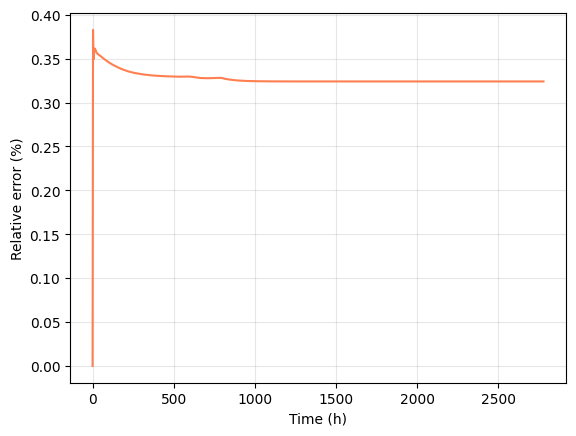

In [7]:
error = np.zeros(np.size(timeOF))
for i in range (1, np.size(timeOF)): 
    error[i]= (abs(xeOF[i]-solution_vector[i])/xeOF[i])*100

plt.plot(figsize=[5,5])
plt.plot(timeOF,error, color='#FF7F50', linewidth=1.5)
plt.grid(which='both', alpha=0.3)
plt.xlabel('Time (h)')
plt.ylabel('Relative error (%)')
plt.savefig("Error.pdf", bbox_inches="tight")

print(F'Maximum error between SCIANTIX and HF = {max(error)} (%).')